# League of Legends - Preprocessing & Feature Engineering

<img src="https://onovia.com/wp-content/uploads/2020/05/lol-logo-rendered-hi-res.png"/>

* Notebook para criação de features e processamento do dataset -> modelos ML
* Criação de Features
    * Level médio
    * Controle de monstros (dragons + riftherald)
    * Controle de mapa (torres destruídas c/ mais força na do mid)
    * "Bom começo" (gold total > 19000, xp total > 18000)
    * Drop em features altamente correlacionadas (deaths - kills, etc.)
* Processamento
    * Modelos lineares
        * Aplicar one-hot-encoding em todas os champions
            * Transformar cada champion -> role (mago, tank e etc) e aí aplicar one-hot
        * Normalizar e aplicar escalonamento em features numéricas
    * Modelos baseados em árvore
        * Features categóricas já estão em formato int (CatBoostAI e LightGBM)

In [24]:
import jovian

jovian.commit(files = ['helper.py'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.ai/nicolasbuen/3-preprocessing-feature-engineering


'https://jovian.ai/nicolasbuen/3-preprocessing-feature-engineering'

In [1]:
# Importando Libs

# Manipulação e Limpeza de Dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Funções Helpers
from helper import xp_to_level, get_champions_role

# scikit-learn
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

sns.set_theme(style="white")
plt.rc("axes.spines", top=False, right=False)
sns.set_context('talk')
pd.set_option('display.max_columns', None)

In [2]:
# Load no Dataset

raw_df = pd.read_csv('data/54k_matches.csv')
raw_df = raw_df.drop('Unnamed: 0', axis=1)
raw_df = raw_df.drop_duplicates(subset='gameID')
raw_df

,gameID,isWinner_blue,totalGold_red,xp_red,nKills_red,nDeaths_red,nAssists_red,minionsKilled_red,jungleMinionsKilled_red,wardsPlaced_red,wardsKilled_red,firstBlood_red,firstTower_red,midTowersDestroyed_red,botTowersDestroyed_red,topTowersDestroyed_red,inhibitorsDestroyed_red,fireDragonsDestroyed_red,airDragonsDestroyed_red,waterDragonsDestroyed_red,earthDragonsDestroyed_red,riftHeraldDestroyed_red,TOP_red,JUNGLE_red,MIDDLE_red,BOTTOM_red,UTILITY_red,totalGold_blue,xp_blue,nKills_blue,nDeaths_blue,nAssists_blue,minionsKilled_blue,jungleMinionsKilled_blue,wardsPlaced_blue,wardsKilled_blue,firstBlood_blue,firstTower_blue,midTowersDestroyed_blue,botTowersDestroyed_blue,topTowersDestroyed_blue,inhibitorsDestroyed_blue,fireDragonsDestroyed_blue,airDragonsDestroyed_blue,waterDragonsDestroyed_blue,earthDragonsDestroyed_blue,riftHeraldDestroyed_blue,TOP_blue,JUNGLE_blue,MIDDLE_blue,BOTTOM_blue,UTILITY_blue
0,2209059589,True,17214,17604,8,7,6,204,59,17,3,1,0,0,0,0,0,0,0,0,1,0,164,104,103,157,12,16628,17593,7,8,6,217,56,15,1,0,0,0,0,0,0,0,0,0,0,0,58,64,105,45,412
1,2209068903,False,17716,17651,9,10,12,194,50,17,1,0,0,0,0,0,0,0,0,1,0,0,24,14,38,81,40,19229,17683,10,9,15,227,64,17,2,1,0,0,0,0,0,0,0,0,0,0,85,141,30,202,497
2,2209108244,True,16943,19396,5,3,6,238,65,17,2,1,0,0,0,0,0,0,0,0,0,0,150,157,79,67,25,14980,17876,3,5,1,250,44,16,4,0,0,0,0,0,0,0,0,0,0,0,85,33,30,222,111
3,2209077995,False,17221,18862,10,6,6,207,64,18,3,0,0,0,0,0,0,0,0,0,0,0,150,141,4,145,111,16408,16230,6,10,7,216,38,19,1,1,0,0,0,0,0,0,0,0,1,0,157,60,45,222,412
4,2209117048,True,16109,19354,7,9,2,197,69,14,1,0,0,0,0,0,0,0,0,0,0,1,24,2,37,222,26,17562,19718,9,7,4,226,62,20,3,1,0,0,0,0,0,0,0,0,1,0,126,120,45,145,412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54133,2176919357,False,16440,17495,7,2,7,234,48,13,4,0,0,0,0,0,0,0,0,1,0,0,164,234,3,202,35,14611,15975,2,7,3,211,47,14,4,1,0,0,0,0,0,0,0,0,0,1,114,203,4,21,50
54134,2176879019,False,18691,19151,9,4,9,230,52,17,1,1,0,0,0,0,0,0,0,0,1,0,234,35,38,21,147,15805,17937,4,9,6,224,57,13,6,0,0,0,0,0,0,0,0,0,0,0,39,104,105,79,235
54135,2175441438,False,17306,19096,7,9,5,253,68,12,2,1,0,0,0,0,0,1,0,0,0,0,122,234,13,22,53,18712,19561,9,7,10,213,60,20,4,0,0,0,0,0,0,0,0,0,0,0,777,876,112,21,43
54136,2175286147,False,19199,19407,10,6,10,223,58,19,3,0,0,0,0,0,0,0,0,0,0,0,150,64,105,202,63,16779,17405,6,10,6,229,58,16,1,1,0,0,0,0,0,0,0,0,0,1,39,107,25,3,235


In [3]:
print(f"Número de Observações: {raw_df.shape[0]}\nNúmero de Variáveis: {raw_df.shape[1]}")

Número de Observações: 54120
Número de Variáveis: 52


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54120 entries, 0 to 54137
Data columns (total 52 columns):
gameID                        54120 non-null int64
isWinner_blue                 54120 non-null bool
totalGold_red                 54120 non-null int64
xp_red                        54120 non-null int64
nKills_red                    54120 non-null int64
nDeaths_red                   54120 non-null int64
nAssists_red                  54120 non-null int64
minionsKilled_red             54120 non-null int64
jungleMinionsKilled_red       54120 non-null int64
wardsPlaced_red               54120 non-null int64
wardsKilled_red               54120 non-null int64
firstBlood_red                54120 non-null int64
firstTower_red                54120 non-null int64
midTowersDestroyed_red        54120 non-null int64
botTowersDestroyed_red        54120 non-null int64
topTowersDestroyed_red        54120 non-null int64
inhibitorsDestroyed_red       54120 non-null int64
fireDragonsDestroyed_red 

## Feature Engineering

In [5]:
# # criar algumas features importantes
df = raw_df.copy()

for c in ['blue', 'red']:
    # xp to level
    df[f'meanLevel_{c}'] = (df[f'xp_{c}']/5).apply(xp_to_level)

    # objective_control

    # monster
    df[f'monsterControl_{c}'] = (df[f'fireDragonsDestroyed_{c}'] + df[f'airDragonsDestroyed_{c}']
                                 + df[f'waterDragonsDestroyed_{c}'] + df[f'earthDragonsDestroyed_{c}']
                                 + df[f'riftHeraldDestroyed_{c}'])
    # tower 
    df[f'mapControl_{c}'] = (df[f'botTowersDestroyed_{c}'] + df[f'topTowersDestroyed_{c}']
                             + 2*df[f'midTowersDestroyed_{c}'])

    # great start
    df[f'greatStart_{c}'] = np.where(np.logical_and(df[f'xp_{c}'] > 18000, df[f'totalGold_{c}'] > 19000),
                                     1, 0)
    
    # champion -> role
    for lane in ['MIDDLE', 'BOTTOM', 'TOP', 'JUNGLE', 'UTILITY']:
        df[f'role{lane}_{c}'] = df[f'{lane}_{c}'].apply(get_champions_role)

df['deltaGold'] = df['totalGold_blue'] - df['totalGold_red']
df['isWinner_blue'] = np.where(df['isWinner_blue'], 1, 0)

In [6]:
df.columns

Index(['gameID', 'isWinner_blue', 'totalGold_red', 'xp_red', 'nKills_red',
       'nDeaths_red', 'nAssists_red', 'minionsKilled_red',
       'jungleMinionsKilled_red', 'wardsPlaced_red', 'wardsKilled_red',
       'firstBlood_red', 'firstTower_red', 'midTowersDestroyed_red',
       'botTowersDestroyed_red', 'topTowersDestroyed_red',
       'inhibitorsDestroyed_red', 'fireDragonsDestroyed_red',
       'airDragonsDestroyed_red', 'waterDragonsDestroyed_red',
       'earthDragonsDestroyed_red', 'riftHeraldDestroyed_red', 'TOP_red',
       'JUNGLE_red', 'MIDDLE_red', 'BOTTOM_red', 'UTILITY_red',
       'totalGold_blue', 'xp_blue', 'nKills_blue', 'nDeaths_blue',
       'nAssists_blue', 'minionsKilled_blue', 'jungleMinionsKilled_blue',
       'wardsPlaced_blue', 'wardsKilled_blue', 'firstBlood_blue',
       'firstTower_blue', 'midTowersDestroyed_blue', 'botTowersDestroyed_blue',
       'topTowersDestroyed_blue', 'inhibitorsDestroyed_blue',
       'fireDragonsDestroyed_blue', 'airDragonsDestroy

In [7]:
df_linear = df.copy()

lanes = ['TOP', 'MIDDLE', 'JUNGLE', 'UTILITY', 'BOTTOM']

for column in [col for col in df.columns if any(lane in col for lane in lanes)]:
    df.loc[:, column] = LabelEncoder().fit_transform(np.array(df[column]).reshape(-1, 1))  

C:\Users\bueni\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
df

,gameID,isWinner_blue,totalGold_red,xp_red,nKills_red,nDeaths_red,nAssists_red,minionsKilled_red,jungleMinionsKilled_red,wardsPlaced_red,wardsKilled_red,firstBlood_red,firstTower_red,midTowersDestroyed_red,botTowersDestroyed_red,topTowersDestroyed_red,inhibitorsDestroyed_red,fireDragonsDestroyed_red,airDragonsDestroyed_red,waterDragonsDestroyed_red,earthDragonsDestroyed_red,riftHeraldDestroyed_red,TOP_red,JUNGLE_red,MIDDLE_red,BOTTOM_red,UTILITY_red,totalGold_blue,xp_blue,nKills_blue,nDeaths_blue,nAssists_blue,minionsKilled_blue,jungleMinionsKilled_blue,wardsPlaced_blue,wardsKilled_blue,firstBlood_blue,firstTower_blue,midTowersDestroyed_blue,botTowersDestroyed_blue,topTowersDestroyed_blue,inhibitorsDestroyed_blue,fireDragonsDestroyed_blue,airDragonsDestroyed_blue,waterDragonsDestroyed_blue,earthDragonsDestroyed_blue,riftHeraldDestroyed_blue,TOP_blue,JUNGLE_blue,MIDDLE_blue,BOTTOM_blue,UTILITY_blue,meanLevel_blue,monsterControl_blue,mapControl_blue,greatStart_blue,roleMIDDLE_blue,roleBOTTOM_blue,roleTOP_blue,roleJUNGLE_blue,roleUTILITY_blue,meanLevel_red,monsterControl_red,mapControl_red,greatStart_red,roleMIDDLE_red,roleBOTTOM_red,roleTOP_red,roleJUNGLE_red,roleUTILITY_red,deltaGold
0,2209059589,1,17214,17604,8,7,6,204,59,17,3,1,0,0,0,0,0,0,0,0,1,0,114,87,86,109,11,16628,17593,7,8,6,217,56,15,1,0,0,0,0,0,0,0,0,0,0,0,53,58,88,44,122,7.0,0,0,0,1,3,5,5,4,7.0,1,0,0,3,9,5,10,11,-586
1,2209068903,0,17716,17651,9,10,12,194,50,17,1,0,0,0,0,0,0,0,0,1,0,0,23,13,37,70,39,19229,17683,10,9,15,227,64,17,2,1,0,0,0,0,0,0,0,0,0,0,75,106,29,116,128,7.0,0,0,0,2,8,2,9,4,7.0,1,0,0,1,8,9,11,6,1513
2,2209108244,1,16943,19396,5,3,6,238,65,17,2,1,0,0,0,0,0,0,0,0,0,0,109,113,69,59,24,14980,17876,3,5,1,250,44,16,4,0,0,0,0,0,0,0,0,0,0,0,75,32,29,118,85,7.0,0,0,0,2,8,2,11,11,7.0,0,0,0,11,8,10,9,4,-1963
3,2209077995,0,17221,18862,10,6,6,207,64,18,3,0,0,0,0,0,0,0,0,0,0,0,109,108,3,106,86,16408,16230,6,10,7,216,38,19,1,1,0,0,0,0,0,0,0,0,1,0,112,54,44,118,122,7.0,1,0,0,3,8,9,5,4,7.0,0,0,0,3,8,10,9,11,-813
4,2209117048,1,16109,19354,7,9,2,197,69,14,1,0,0,0,0,0,0,0,0,0,0,1,23,1,36,116,25,17562,19718,9,7,4,226,62,20,3,1,0,0,0,0,0,0,0,0,1,0,101,98,44,108,122,7.0,1,0,0,3,8,0,5,4,7.0,1,0,0,6,8,9,5,10,1453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54133,2176919357,0,16440,17495,7,2,7,234,48,13,4,0,0,0,0,0,0,0,0,1,0,0,114,122,2,114,34,14611,15975,2,7,3,211,47,14,4,1,0,0,0,0,0,0,0,0,0,1,95,117,3,20,45,7.0,1,0,0,3,8,9,8,2,7.0,1,0,0,12,8,5,9,1,-1829
54134,2176879019,0,18691,19151,9,4,9,230,52,17,1,1,0,0,0,0,0,0,0,0,1,0,120,34,37,20,99,15805,17937,4,9,6,224,57,13,6,0,0,0,0,0,0,0,0,0,0,0,38,86,88,68,112,7.0,0,0,0,1,11,5,10,8,7.0,1,0,0,1,8,9,1,6,-2886
54135,2175441438,0,17306,19096,7,9,5,253,68,12,2,1,0,0,0,0,0,1,0,0,0,0,98,122,12,21,47,18712,19561,9,7,10,213,60,20,4,0,0,0,0,0,0,0,0,0,0,0,146,147,93,20,41,7.0,0,0,0,2,8,9,9,6,7.0,1,0,0,2,8,7,9,4,1406
54136,2175286147,0,19199,19407,10,6,10,223,58,19,3,0,0,0,0,0,0,0,0,0,0,0,109,59,88,114,55,16779,17405,6,10,6,229,58,16,1,1,0,0,0,0,0,0,0,0,0,1,38,89,24,2,112,7.0,1,0,0,4,12,5,1,8,7.0,0,0,1,1,8,10,5,3,-2420


In [9]:
df_boosted_no_out = df.copy()

roles = [col for col in df_boosted_no_out.columns
                if any(lane in col
                       for lane in lanes)]

for role in roles:
    part = df_boosted_no_out[role].value_counts(normalize=True)
    
    non_outliers = np.array(part[part > 0.001].index)
    
    df_boosted_no_out = df_boosted_no_out[df_boosted_no_out[role].isin(non_outliers)]

In [10]:
df.to_csv('data\df_boosted.csv')

df_boosted_no_out.to_csv('data\df_boosted_dropout.csv')

## Dataset p/ Modelos Lineares

<ipython-input-11-c2c3f97d4db7>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(3,2))


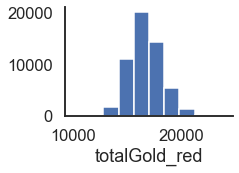

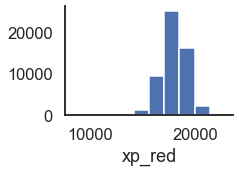

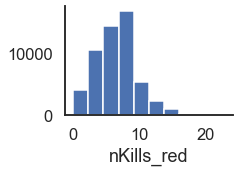

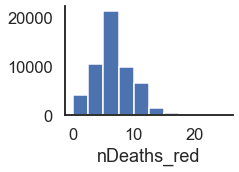

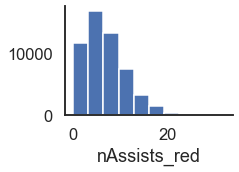

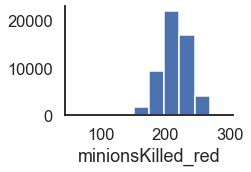

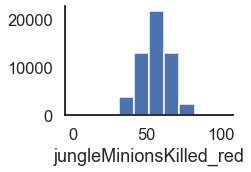

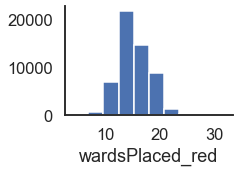

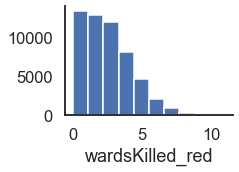

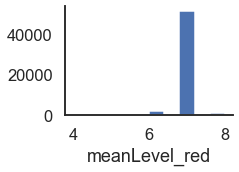

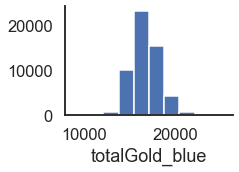

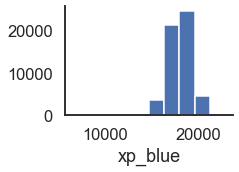

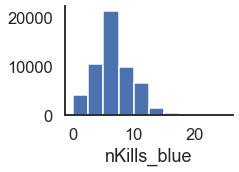

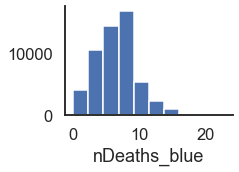

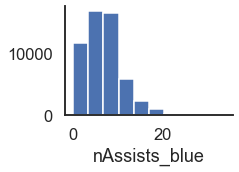

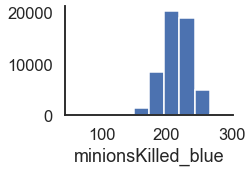

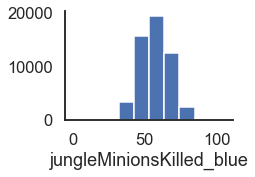

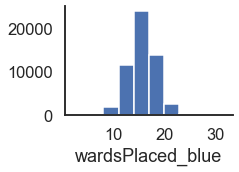

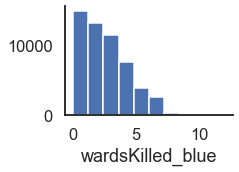

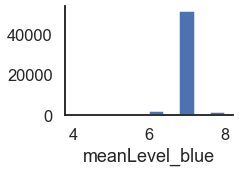

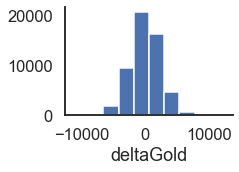

In [11]:
# checking for normalization needs

num_columns = ['totalGold_red', 'xp_red', 'nKills_red', 'nDeaths_red',
               'nAssists_red', 'minionsKilled_red', 'jungleMinionsKilled_red',
               'wardsPlaced_red', 'wardsKilled_red', 'meanLevel_red',
               'totalGold_blue', 'xp_blue', 'nKills_blue', 'nDeaths_blue',
               'nAssists_blue', 'minionsKilled_blue', 'jungleMinionsKilled_blue',
               'wardsPlaced_blue', 'wardsKilled_blue', 'meanLevel_blue',
               'deltaGold']

for col in num_columns:
    fig, ax = plt.subplots(figsize=(3,2))
    
    ax = plt.hist(df_linear[col])
    ax = plt.xlabel(col)

Observações:

* Nenhuma das variáveis possui outliers expressivos e a maioria se aproxima da curva normal. 
* Features c/ level médio possuem variância muito baixa, o que pode ser um problema para o modelo;
* wardsKilled com mediana e moda à esquerda e próximo de zero

<ipython-input-12-b45f928466f6>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, figsize=(12,2))


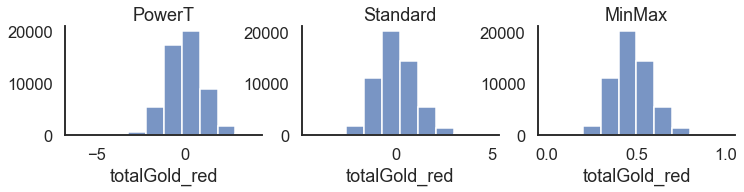

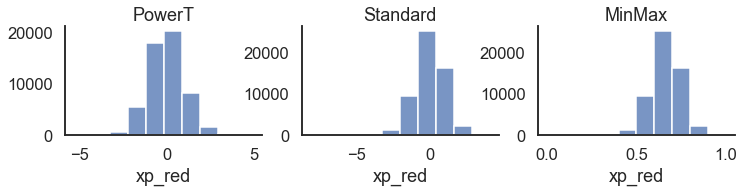

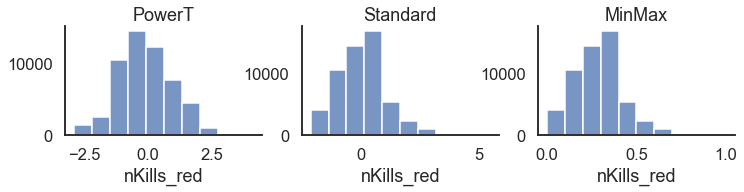

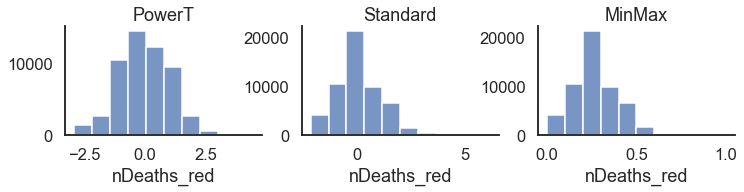

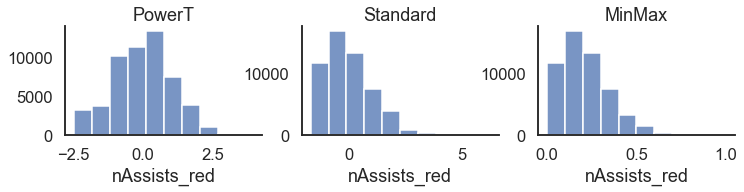

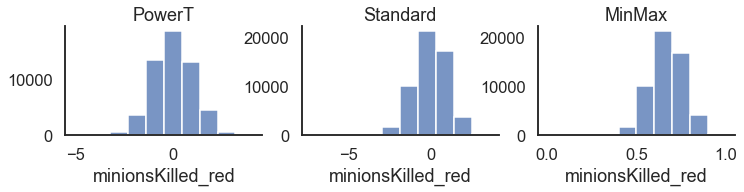

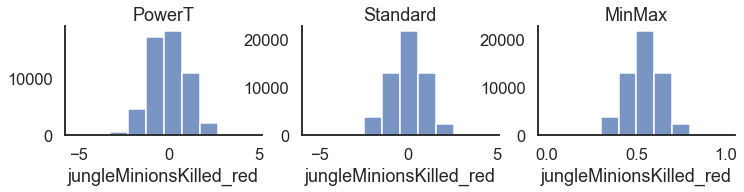

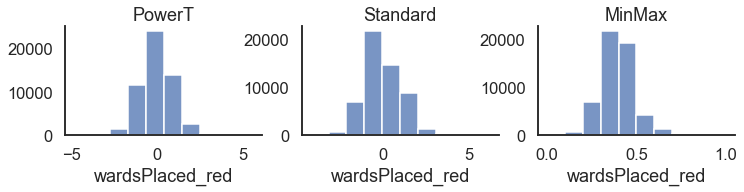

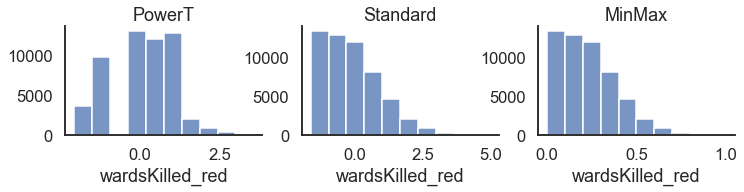

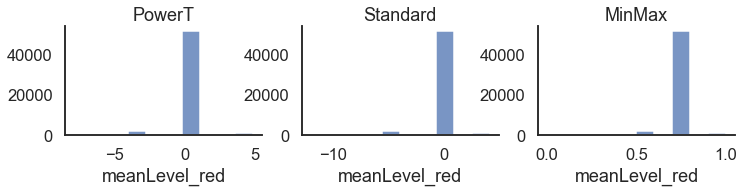

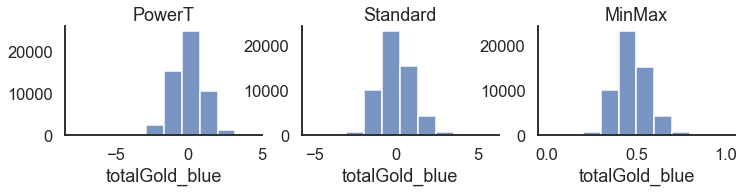

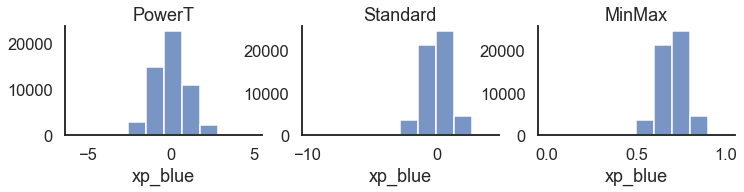

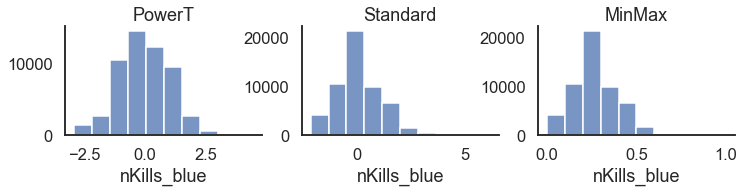

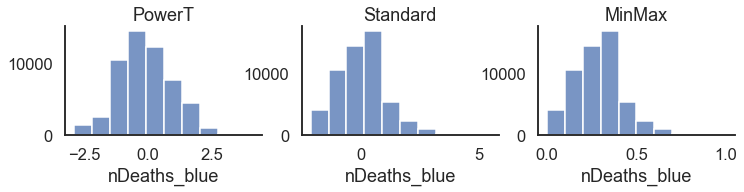

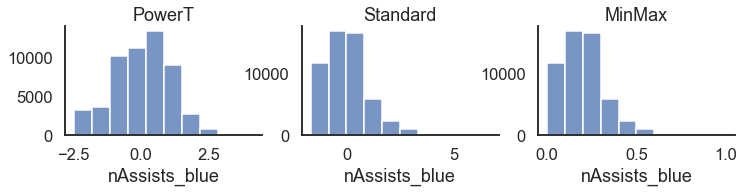

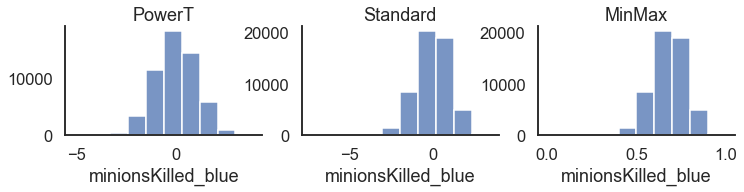

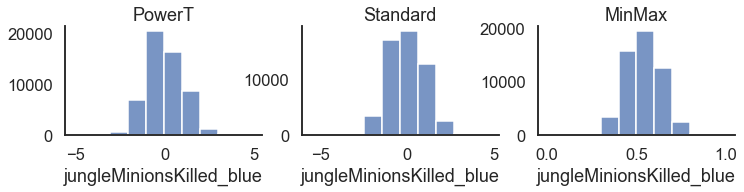

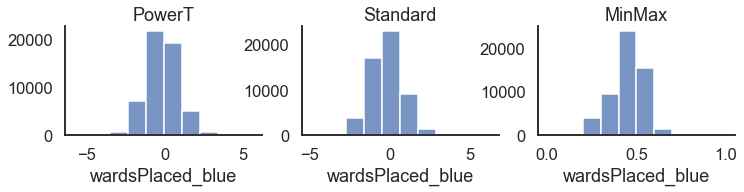

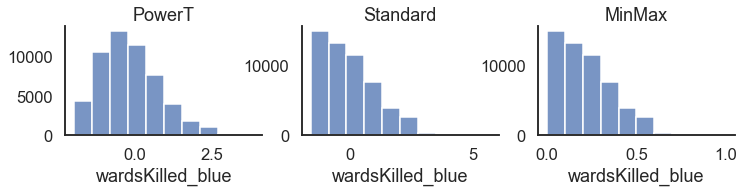

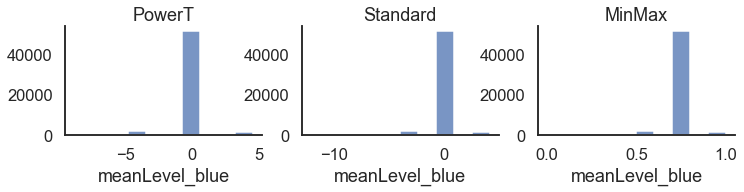

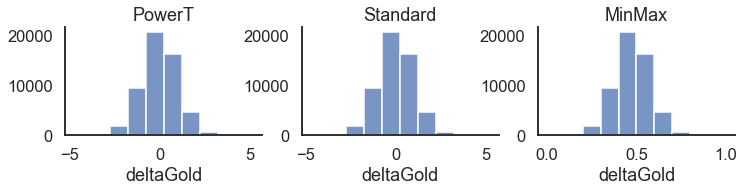

In [12]:
# testando alguns transformadores 

ward_killed_cols = ['wardsKilled_red', 'wardsKilled_blue']

for col in num_columns:
    fig, axs = plt.subplots(1, 3, figsize=(12,2))
    
    x = np.array(df_linear[col]).reshape(-1, 1)
    
    # powertransformer c/ negativos
    pt = PowerTransformer(method='yeo-johnson', standardize = True)
    x_pt = pt.fit_transform(x)
    
    # standard scaler
    ss = StandardScaler()
    x_ss = ss.fit_transform(x)
    
    # minmax scaler
    mm = MinMaxScaler()
    x_mm = mm.fit_transform(x)
    
    sns.histplot(x_pt, ax = axs[0], bins = 10)
    sns.histplot(x_ss, ax = axs[1], bins = 10)
    sns.histplot(x_mm, ax = axs[2], bins = 10)
    
    for ax, scaler in zip(axs, ['PowerT', 'Standard', 'MinMax']):
        ax.set(title = scaler,
               xlabel = col,
               ylabel = '')
        ax.get_legend().remove()
        

Usar a transformação Yeo-Johnson retornou bons resultados para os principais problemas de distribuição. Utilizarei ele para normalizar e standardizar as features. 

Além disso, vou dropar as colunas `meanLevel` recém criadas e aquelas que contém o número de mortes, devido a correlação máxima com o número de kills.

In [13]:
np.array(df_linear[col]).reshape(-1, 1)

array([[ -586],
       [ 1513],
       [-1963],
       ...,
       [ 1406],
       [-2420],
       [ -779]], dtype=int64)

In [14]:
for col in num_columns:
    pt = PowerTransformer(method='yeo-johnson', standardize = True)
    x = pt.fit_transform(np.array(df_linear[col]).reshape(-1, 1))
    df_linear.loc[:, col] = x

df_linear = df_linear.drop(['meanLevel_blue', 'meanLevel_red', 'nDeaths_blue', 'nDeaths_red'], axis = 1)

In [15]:
df_linear

,gameID,isWinner_blue,totalGold_red,xp_red,nKills_red,nAssists_red,minionsKilled_red,jungleMinionsKilled_red,wardsPlaced_red,wardsKilled_red,firstBlood_red,firstTower_red,midTowersDestroyed_red,botTowersDestroyed_red,topTowersDestroyed_red,inhibitorsDestroyed_red,fireDragonsDestroyed_red,airDragonsDestroyed_red,waterDragonsDestroyed_red,earthDragonsDestroyed_red,riftHeraldDestroyed_red,TOP_red,JUNGLE_red,MIDDLE_red,BOTTOM_red,UTILITY_red,totalGold_blue,xp_blue,nKills_blue,nAssists_blue,minionsKilled_blue,jungleMinionsKilled_blue,wardsPlaced_blue,wardsKilled_blue,firstBlood_blue,firstTower_blue,midTowersDestroyed_blue,botTowersDestroyed_blue,topTowersDestroyed_blue,inhibitorsDestroyed_blue,fireDragonsDestroyed_blue,airDragonsDestroyed_blue,waterDragonsDestroyed_blue,earthDragonsDestroyed_blue,riftHeraldDestroyed_blue,TOP_blue,JUNGLE_blue,MIDDLE_blue,BOTTOM_blue,UTILITY_blue,monsterControl_blue,mapControl_blue,greatStart_blue,roleMIDDLE_blue,roleBOTTOM_blue,roleTOP_blue,roleJUNGLE_blue,roleUTILITY_blue,monsterControl_red,mapControl_red,greatStart_red,roleMIDDLE_red,roleBOTTOM_red,roleTOP_red,roleJUNGLE_red,roleUTILITY_red,deltaGold
0,2209059589,1,0.399783,-0.394072,0.552117,-0.061353,-0.535046,0.295115,0.652913,0.271073,1,0,0,0,0,0,0,0,0,1,0,164,104,103,157,12,0.000848,-0.453363,0.252573,-0.064413,0.017180,-0.107468,-0.084411,-0.977494,0,0,0,0,0,0,0,0,0,0,0,58,64,105,45,412,0,0,0,Assassin,Burst,Diver,Diver,Catcher,1,0,0,Burst,Skirmisher,Diver,Specialist,Vanguard,-0.250889
1,2209068903,0,0.714456,-0.355012,0.847888,1.225572,-0.972659,-0.587906,0.652913,-1.068459,0,0,0,0,0,0,0,0,1,0,0,24,14,38,81,40,1.588013,-0.378863,1.136685,1.731149,0.493815,0.678345,0.650244,-0.247396,1,0,0,0,0,0,0,0,0,0,0,85,141,30,202,497,0,0,0,BattleMage,Marksman,BattleMage,Skirmisher,Catcher,1,0,0,Assassin,Marksman,Skirmisher,Vanguard,Enchanter,0.618169
2,2209108244,1,0.224741,1.209964,-0.434683,-0.061353,1.086700,0.888098,0.652913,-0.339397,1,0,0,0,0,0,0,0,0,0,0,150,157,79,67,25,-1.180482,-0.217216,-1.211908,-1.820222,1.655616,-1.262970,0.285568,0.882641,0,0,0,0,0,0,0,0,0,0,0,85,33,30,222,111,0,0,0,BattleMage,Marksman,BattleMage,Vanguard,Vanguard,0,0,0,Vanguard,Marksman,Specialist,Skirmisher,Catcher,-0.820609
3,2209077995,0,0.404255,0.707035,1.131101,-0.061353,-0.400243,0.789046,1.011106,0.271073,0,0,0,0,0,0,0,0,0,0,0,150,141,4,145,111,-0.147942,-1.514162,-0.074521,0.184388,-0.029525,-1.828568,1.365098,-0.977494,1,0,0,0,0,0,0,0,0,1,0,157,60,45,222,412,1,0,0,Burst,Marksman,Skirmisher,Diver,Catcher,0,0,0,Burst,Marksman,Specialist,Skirmisher,Vanguard,-0.344812
4,2209117048,1,-0.338440,1.169628,0.241731,-1.347927,-0.843275,1.285154,-0.458173,-1.068459,0,0,0,0,0,0,0,0,0,0,1,24,2,37,222,26,0.605444,1.457533,0.855680,-0.631788,0.445370,0.480837,1.715885,0.357113,1,0,0,0,0,0,0,0,0,1,0,126,120,45,145,412,1,0,0,Burst,Marksman,Artillery,Diver,Catcher,1,0,0,Enchanter,Marksman,Skirmisher,Diver,Specialist,0.593320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54133,2176919357,0,-0.110337,-0.484047,0.241731,0.187898,0.885282,-0.782977,-0.842405,0.806212,0,0,0,0,0,0,0,0,1,0,0,164,234,3,202,35,-1.468049,-1.698793,-1.673868,-0.965450,-0.260424,-0.976961,-0.460111,0.882641,1,0,0,0,0,0,0,0,0,0,1,114,203,4,21,50,1,0,0,Burst,Marksman,Skirmisher,Marksman,BattleMage,1,0,0,Warden,Marksman,Diver,Skirmisher,Assassin,-0.765170
54134,2176879019,0,1.292717,0.976552,0.847888,0.637893,0.686679,-0.392397,0.652913,-1.068459,1,0,0,0,0,0,0,0,0,1,0,234,35,38,21,147,-0.569282,-0.165588,-0.799783,-0.064413,0.348999,-0.009872,-0.842011,1.781253,0,0,0,0,0,0,0,0,0,0,0,39,104,105,79,235,0,0,0,Assassin,Vanguard,Diver,Specialist,Marksman,1,0,0,Assassin,Marksman,Skirmisher,Assassin,Enchanter,-1.202473
54135,2175441438,0,0.458367,0.924777,0.241731,-0.331768,1.866946,1.185766,-1.2

In [16]:
df_linear_no_out = df_linear.copy()

In [17]:
roles = [col for col in df_linear_no_out.columns
                if any(col.startswith(lane)
                       for lane in lanes)]

for role in roles:
    part = df_linear_no_out[role].value_counts(normalize=True)
    
    non_outliers = np.array(part[part > 0.001].index)
    
    df_linear_no_out = df_linear_no_out[df_linear_no_out[role].isin(non_outliers)]

In [18]:
df_linear_no_out.shape

(41864, 67)

Por último, utilizarei o one-hot-encoding nas features que contém as roles dos champions:

In [19]:
# drop champions (high cardinality)

df_linear_sem_champion = df_linear.drop(roles, axis=1)

In [20]:
champion_col = [col for col in df_linear.columns
                    if any(lane in col
                           for lane in lanes)]

df_linear = pd.get_dummies(data=df_linear, columns=champion_col)

df_linear_no_out = pd.get_dummies(data=df_linear_no_out, columns=champion_col)

role_cols = [x for x in df_linear_sem_champion.columns if 'role' in x]

df_linear_sem_champion = pd.get_dummies(data = df_linear_sem_champion,
                                        columns = role_cols)

In [21]:
df_linear.head()

,gameID,isWinner_blue,totalGold_red,xp_red,nKills_red,nAssists_red,minionsKilled_red,jungleMinionsKilled_red,wardsPlaced_red,wardsKilled_red,firstBlood_red,firstTower_red,midTowersDestroyed_red,botTowersDestroyed_red,topTowersDestroyed_red,inhibitorsDestroyed_red,fireDragonsDestroyed_red,airDragonsDestroyed_red,waterDragonsDestroyed_red,earthDragonsDestroyed_red,riftHeraldDestroyed_red,totalGold_blue,xp_blue,nKills_blue,nAssists_blue,minionsKilled_blue,jungleMinionsKilled_blue,wardsPlaced_blue,wardsKilled_blue,firstBlood_blue,firstTower_blue,midTowersDestroyed_blue,botTowersDestroyed_blue,topTowersDestroyed_blue,inhibitorsDestroyed_blue,fireDragonsDestroyed_blue,airDragonsDestroyed_blue,waterDragonsDestroyed_blue,earthDragonsDestroyed_blue,riftHeraldDestroyed_blue,monsterControl_blue,mapControl_blue,greatStart_blue,monsterControl_red,mapControl_red,greatStart_red,deltaGold,TOP_red_1,TOP_red_2,TOP_red_3,TOP_red_4,TOP_red_5,TOP_red_6,TOP_red_7,TOP_red_8,TOP_red_9,TOP_red_10,TOP_red_11,TOP_red_12,TOP_red_13,TOP_red_14,TOP_red_15,TOP_red_16,TOP_red_17,TOP_red_18,TOP_red_19,TOP_red_20,TOP_red_21,TOP_red_22,TOP_red_23,TOP_red_24,TOP_red_25,TOP_red_26,TOP_red_27,TOP_red_28,TOP_red_29,TOP_red_30,TOP_red_31,TOP_red_32,TOP_red_33,TOP_red_34,TOP_red_35,TOP_red_36,TOP_red_37,TOP_red_38,TOP_red_39,TOP_red_40,TOP_red_41,TOP_red_42,TOP_red_43,TOP_red_44,TOP_red_45,TOP_red_48,TOP_red_50,TOP_red_51,TOP_red_53,TOP_red_54,TOP_red_55,TOP_red_56,TOP_red_57,TOP_red_58,TOP_red_59,TOP_red_60,TOP_red_61,TOP_red_62,TOP_red_63,TOP_red_64,TOP_red_67,TOP_red_68,TOP_red_69,TOP_red_72,TOP_red_74,TOP_red_75,TOP_red_76,TOP_red_77,TOP_red_78,TOP_red_79,TOP_red_80,TOP_red_81,TOP_red_82,TOP_red_83,TOP_red_84,TOP_red_85,TOP_red_86,TOP_red_89,TOP_red_90,TOP_red_91,TOP_red_92,TOP_red_96,TOP_red_98,TOP_red_99,TOP_red_101,TOP_red_102,TOP_red_104,TOP_red_105,TOP_red_106,TOP_red_107,TOP_red_111,TOP_red_112,TOP_red_113,TOP_red_114,TOP_red_115,TOP_red_117,TOP_red_119,TOP_red_121,TOP_red_122,TOP_red_126,TOP_red_127,TOP_red_131,TOP_red_133,TOP_red_134,TOP_red_136,TOP_red_141,TOP_red_142,TOP_red_143,TOP_red_147,TOP_red_150,TOP_red_154,TOP_red_157,TOP_red_161,TOP_red_163,TOP_red_164,TOP_red_201,TOP_red_202,TOP_red_203,TOP_red_222,TOP_red_223,TOP_red_234,TOP_red_235,TOP_red_236,TOP_red_240,TOP_red_245,TOP_red_246,TOP_red_254,TOP_red_266,TOP_red_267,TOP_red_268,TOP_red_350,TOP_red_360,TOP_red_420,TOP_red_421,TOP_red_427,TOP_red_429,TOP_red_432,TOP_red_497,TOP_red_498,TOP_red_516,TOP_red_517,TOP_red_518,TOP_red_523,TOP_red_526,TOP_red_555,TOP_red_777,TOP_red_875,TOP_red_876,JUNGLE_red_1,JUNGLE_red_2,JUNGLE_red_3,JUNGLE_red_4,JUNGLE_red_5,JUNGLE_red_6,JUNGLE_red_7,JUNGLE_red_8,JUNGLE_red_9,JUNGLE_red_10,JUNGLE_red_11,JUNGLE_red_12,JUNGLE_red_13,JUNGLE_red_14,JUNGLE_red_15,JUNGLE_red_16,JUNGLE_red_17,JUNGLE_red_18,JUNGLE_red_19,JUNGLE_red_20,JUNGLE_red_21,JUNGLE_red_22,JUNGLE_red_23,JUNGLE_red_24,JUNGLE_red_25,JUNGLE_red_26,JUNGLE_red_27,JUNGLE_red_28,JUNGLE_red_29,JUNGLE_red_30,JUNGLE_red_31,JUNGLE_red_32,JUNGLE_red_33,JUNGLE_red_34,JUNGLE_red_35,JUNGLE_red_36,JUNGLE_red_37,JUNGLE_red_38,JUNGLE_red_39,JUNGLE_red_40,JUNGLE_red_41,JUNGLE_red_42,JUNGLE_red_43,JUNGLE_red_44,JUNGLE_red_45,JUNGLE_red_48,JUNGLE_red_50,JUNGLE_red_51,JUNGLE_red_53,JUNGLE_red_54,JUNGLE_red_55,JUNGLE_red_56,JUNGLE_red_57,JUNGLE_red_58,JUNGLE_red_59,JUNGLE_red_60,JUNGLE_red_61,JUNGLE_red_62,JUNGLE_red_63,JUNGLE_red_64,JUNGLE_red_67,JUNGLE_red_68,JUNGLE_red_69,JUNGLE_red_72,JUNGLE_red_74,JUNGLE_red_75,JUNGLE_red_76,JUNGLE_red_77,JUNGLE_red_78,JUNGLE_red_79,JUNGLE_red_80,JUNGLE_red_81,JUNGLE_red_82,JUNGLE_red_83,JUNGLE_red_84,JUNGLE_red_85,JUNGLE_red_86,JUNGLE_red_89,JUNGLE_red_90,JUNGLE_red_91,JUNGLE_red_92,JUNGLE_red_96,JUNGLE_red_98,JUNGLE_red_99,JUNGLE_red_101,JUNGLE_red_102,JUNGLE_red_103,JUNGLE_red_104,JUNGLE_red_105,JUNGLE_red_106,JUNGLE_red_107,JUNGLE_red_110,JUNGLE_red_111,JUNGLE_red_112,JUNGLE_red_113,JUNGLE_red_114,JUNGLE_red_115,JUNGLE_red_117,JUNGLE_red_119,JUNGLE_red_120,JUNGLE_red_121,JUNGLE_re

In [22]:
df_linear_sem_champion.head()

,gameID,isWinner_blue,totalGold_red,xp_red,nKills_red,nAssists_red,minionsKilled_red,jungleMinionsKilled_red,wardsPlaced_red,wardsKilled_red,firstBlood_red,firstTower_red,midTowersDestroyed_red,botTowersDestroyed_red,topTowersDestroyed_red,inhibitorsDestroyed_red,fireDragonsDestroyed_red,airDragonsDestroyed_red,waterDragonsDestroyed_red,earthDragonsDestroyed_red,riftHeraldDestroyed_red,totalGold_blue,xp_blue,nKills_blue,nAssists_blue,minionsKilled_blue,jungleMinionsKilled_blue,wardsPlaced_blue,wardsKilled_blue,firstBlood_blue,firstTower_blue,midTowersDestroyed_blue,botTowersDestroyed_blue,topTowersDestroyed_blue,inhibitorsDestroyed_blue,fireDragonsDestroyed_blue,airDragonsDestroyed_blue,waterDragonsDestroyed_blue,earthDragonsDestroyed_blue,riftHeraldDestroyed_blue,monsterControl_blue,mapControl_blue,greatStart_blue,monsterControl_red,mapControl_red,greatStart_red,deltaGold,roleMIDDLE_blue_Artillery,roleMIDDLE_blue_Assassin,roleMIDDLE_blue_BattleMage,roleMIDDLE_blue_Burst,roleMIDDLE_blue_Catcher,roleMIDDLE_blue_Diver,roleMIDDLE_blue_Enchanter,roleMIDDLE_blue_Juggernaut,roleMIDDLE_blue_Marksman,roleMIDDLE_blue_Skirmisher,roleMIDDLE_blue_Specialist,roleMIDDLE_blue_Vanguard,roleMIDDLE_blue_Warden,roleBOTTOM_blue_Artillery,roleBOTTOM_blue_Assassin,roleBOTTOM_blue_BattleMage,roleBOTTOM_blue_Burst,roleBOTTOM_blue_Catcher,roleBOTTOM_blue_Diver,roleBOTTOM_blue_Enchanter,roleBOTTOM_blue_Juggernaut,roleBOTTOM_blue_Marksman,roleBOTTOM_blue_Skirmisher,roleBOTTOM_blue_Specialist,roleBOTTOM_blue_Vanguard,roleBOTTOM_blue_Warden,roleTOP_blue_Artillery,roleTOP_blue_Assassin,roleTOP_blue_BattleMage,roleTOP_blue_Burst,roleTOP_blue_Catcher,roleTOP_blue_Diver,roleTOP_blue_Enchanter,roleTOP_blue_Juggernaut,roleTOP_blue_Marksman,roleTOP_blue_Skirmisher,roleTOP_blue_Specialist,roleTOP_blue_Vanguard,roleTOP_blue_Warden,roleJUNGLE_blue_Artillery,roleJUNGLE_blue_Assassin,roleJUNGLE_blue_BattleMage,roleJUNGLE_blue_Burst,roleJUNGLE_blue_Catcher,roleJUNGLE_blue_Diver,roleJUNGLE_blue_Enchanter,roleJUNGLE_blue_Juggernaut,roleJUNGLE_blue_Marksman,roleJUNGLE_blue_Skirmisher,roleJUNGLE_blue_Specialist,roleJUNGLE_blue_Vanguard,roleJUNGLE_blue_Warden,roleUTILITY_blue_Artillery,roleUTILITY_blue_Assassin,roleUTILITY_blue_BattleMage,roleUTILITY_blue_Burst,roleUTILITY_blue_Catcher,roleUTILITY_blue_Diver,roleUTILITY_blue_Enchanter,roleUTILITY_blue_Juggernaut,roleUTILITY_blue_Marksman,roleUTILITY_blue_Skirmisher,roleUTILITY_blue_Specialist,roleUTILITY_blue_Vanguard,roleUTILITY_blue_Warden,roleMIDDLE_red_Artillery,roleMIDDLE_red_Assassin,roleMIDDLE_red_BattleMage,roleMIDDLE_red_Burst,roleMIDDLE_red_Catcher,roleMIDDLE_red_Diver,roleMIDDLE_red_Enchanter,roleMIDDLE_red_Juggernaut,roleMIDDLE_red_Marksman,roleMIDDLE_red_Skirmisher,roleMIDDLE_red_Specialist,roleMIDDLE_red_Vanguard,roleMIDDLE_red_Warden,roleBOTTOM_red_Artillery,roleBOTTOM_red_Assassin,roleBOTTOM_red_BattleMage,roleBOTTOM_red_Burst,roleBOTTOM_red_Catcher,roleBOTTOM_red_Diver,roleBOTTOM_red_Enchanter,roleBOTTOM_red_Juggernaut,roleBOTTOM_red_Marksman,roleBOTTOM_red_Skirmisher,roleBOTTOM_red_Specialist,roleBOTTOM_red_Vanguard,roleBOTTOM_red_Warden,roleTOP_red_Artillery,roleTOP_red_Assassin,roleTOP_red_BattleMage,roleTOP_red_Burst,roleTOP_red_Catcher,roleTOP_red_Diver,roleTOP_red_Enchanter,roleTOP_red_Juggernaut,roleTOP_red_Marksman,roleTOP_red_Skirmisher,roleTOP_red_Specialist,roleTOP_red_Vanguard,roleTOP_red_Warden,roleJUNGLE_red_Artillery,roleJUNGLE_red_Assassin,roleJUNGLE_red_BattleMage,roleJUNGLE_red_Burst,roleJUNGLE_red_Catcher,roleJUNGLE_red_Diver,roleJUNGLE_red_Enchanter,roleJUNGLE_red_Juggernaut,roleJUNGLE_red_Marksman,roleJUNGLE_red_Skirmisher,roleJUNGLE_red_Specialist,roleJUNGLE_red_Vanguard,roleJUNGLE_red_Warden,roleUTILITY_red_Artillery,roleUTILITY_red_Assassin,roleUTILITY_red_BattleMage,roleUTILITY_red_Burst,roleUTILITY_red_Catcher,roleUTILITY_red_Diver,roleUTILITY_red_Enchanter,roleUTILITY_red_Juggernaut,roleUTILITY_red_Marksman,roleUTILITY_red_Skirmisher,roleUTILITY_red_Specialist,roleUTILITY_red_Van

In [23]:
# exportar o df_linear

df_linear_sem_champion.to_csv('data/df_linear.csv')

df_linear.to_csv('data/df_linear_sparse.csv')

df_linear_no_out.to_csv('data/df_linear_dropout.csv')